# 

In [22]:
import pandas as pd
import numpy as np
import matplotlib
import plotnine as ggplot
from plotnine import *
%matplotlib inline

import glob
import re

import time

from pandas import DataFrame
from IPython.display import HTML

import sys
sys.path.append("fastai/old/")
#from fastai_v7 import structured

In [23]:
import sys
sys.path.append("fastai/old/")
#from fastai_v7.structured import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder
import os
import re
import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="7"

from pandas import DataFrame
from IPython.display import HTML

import warnings
warnings.filterwarnings(action='once')
warnings.simplefilter('ignore')


### Load data

In [24]:
filelist_loaded = []
filelist = glob.glob("/home/maghoi/pMHC_data/features5/*.csv"); len(filelist)

for i in range(0, len(filelist)):
    df = pd.read_csv(filelist[i])
    filelist_loaded.append(df)

### Extract peptide, mhc, tcr sequences

In [25]:
#Extract names
name_list = []
for i in range(len(filelist_loaded)):
    r = re.compile("features5/(.*).csv")
    result = r.search(filelist[i])
    name_list.append(result.group(1))
name_list = pd.Series(name_list)

In [26]:
def extract_sequence(dfs, i1, i2):
    seq_list = []
    for i in range(len(dfs)):
        seq = dfs[i].Sequence[i1 : i2]
        seq = np.where(seq == "-1", "-", seq)
        seq = "".join(seq)
        seq_list.append(seq)
    return(seq_list)

In [27]:
len(filelist_loaded[0].Sequence)

468

In [28]:
pep_list =  extract_sequence(filelist_loaded, 181, 192)
mhc_list = extract_sequence(filelist_loaded, 0, 181)
tcr_list = extract_sequence(filelist_loaded, 192, 468)

In [29]:
def extract_4th_col_row(df, axis):
    cols = []
    if axis == 1:
        for i in range(0, df.shape[1], 4):
            cols.append(i)
        return df.iloc[:, cols]
    
    if axis == 0:
        for i in range(0, df.shape[0], 4):
            cols.append(i)
        return df.iloc[cols]

In [30]:
#Remove 3/4 rows (replicates)
pep_list = list(extract_4th_col_row(pd.DataFrame(pep_list), 0)[0])
mhc_list = list(extract_4th_col_row(pd.DataFrame(mhc_list), 0)[0])
tcr_list = list(extract_4th_col_row(pd.DataFrame(tcr_list), 0)[0])
name_list2 = list(extract_4th_col_row(pd.DataFrame(name_list), 0)[0])
name_list2 = pd.Series(name_list2)

In [31]:
len(pep_list), len(mhc_list), len(tcr_list)

(366, 366, 366)

In [32]:
from Bio import pairwise2
def pairwise_align_score(seq_list):
    data = np.zeros((366,366))
    for i, p1 in enumerate(seq_list[:]):
        score_list = []

        for p2 in seq_list[:]:
            p1 = p1.strip("-")
            p2 = p2.strip("-")

            #Compute similarity
            a = pairwise2.align.globalms(p1, p2, 1, 0, -1, 0)[0][2]
            val = 0
            if len(p1) != len(p2):
                    val = 1
            score = (a+val) / max(len(p1), len(p2))
            score_list.append(score)
            #print(score, val, a)

        #Append whole row to data
        data[i] = score_list
        if i % 1 == 0:
            print(i, "/", len(seq_list))

    #Create pandas dataframe with correct names
    df = pd.DataFrame(data, index = range(0, 366), columns = range(0, 366))
    return(df)


#### Graph: peptide occurences

In [38]:
import pandas as pd
import numpy as np
import matplotlib
import plotnine as ggplot
from plotnine import *
%matplotlib inline
from collections import Counter


import glob
import re

import time

from pandas import DataFrame
from IPython.display import HTML

import sys
sys.path.append("fastai/old/")
#from fastai_v7 import structured

In [39]:
#Extract partitions according to indices in name_list
pep_list = pd.Series(pep_list)
p0 = pep_list[name_list2.str.contains(".*0p.*")]
p1 = pep_list[name_list2.str.contains(".*1p.*")]
p2 = pep_list[name_list2.str.contains(".*2p.*")]
p3 = pep_list[name_list2.str.contains(".*3p.*")]
p4 = pep_list[name_list2.str.contains(".*4p.*")]

tcr_list = pd.Series(tcr_list)
tp0 = tcr_list[name_list2.str.contains(".*0p.*")]
tp1 = tcr_list[name_list2.str.contains(".*1p.*")]
tp2 = tcr_list[name_list2.str.contains(".*2p.*")]
tp3 = tcr_list[name_list2.str.contains(".*3p.*")]
tp4 = tcr_list[name_list2.str.contains(".*4p.*")]

mhc_list = pd.Series(mhc_list)
mp0 = mhc_list[name_list2.str.contains(".*0p.*")]
mp1 = mhc_list[name_list2.str.contains(".*1p.*")]
mp2 = mhc_list[name_list2.str.contains(".*2p.*")]
mp3 = mhc_list[name_list2.str.contains(".*3p.*")]
mp4 = mhc_list[name_list2.str.contains(".*4p.*")]

In [40]:
df = pd.DataFrame(Counter(p0).most_common())
melt_df = pd.melt(df)

melt_df["Validation set"] = pd.DataFrame(["1"]*len(melt_df))

In [41]:
len(melt_df), sum(melt_df["value"])

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [42]:
round(28/65, 2)*100

43.0

In [43]:
peps = [p0, p1, p2, p3, p4]
mhcs = [mp0, mp1, mp2, mp3, mp4]
tcrs = [tp0, tp1, tp2, tp3, tp4]

In [44]:
dfs[0]

IndexError: list index out of range

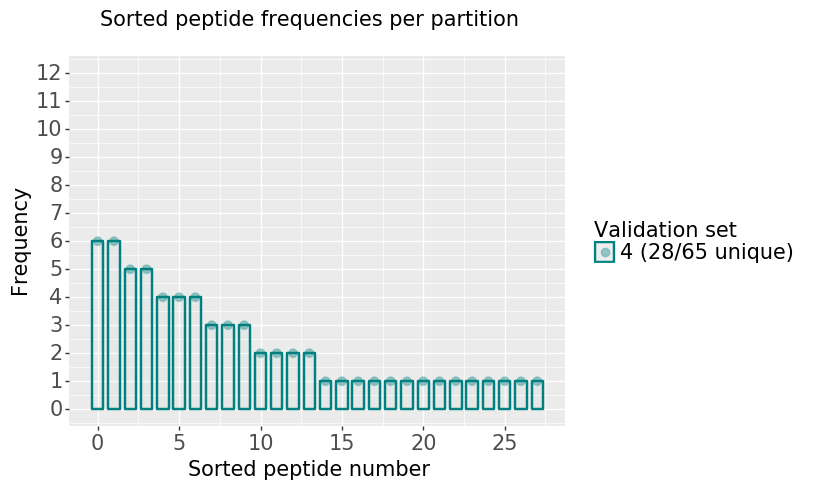

<ggplot: (8744462974016)>

In [191]:
dfs = []
for i in range(0, 5):
    melt_df = pd.DataFrame(Counter(peps[i]).most_common())
    melt_df[0] = melt_df.index
    melt_df.columns = ["variable", "value"]
    
    #text
    #unique = round((len(melt_df) / sum(melt_df["value"]))*100, 1)
    #text = str(i) + " (" + str(unique) + "% unique)"
    unique = str(len(melt_df)) + "/" + str(sum(melt_df["value"]))
    text = str(i) + " ("+ unique + " unique)"
    melt_df["Validation set"] = pd.DataFrame([text]*len(melt_df))
    dfs.append(melt_df)

plot = (ggplot(melt_df, aes("variable", "value"))
        #+ scale_color_discrete()
        + scale_y_continuous(
                            breaks = range(0, 90, 1))
        + scale_x_continuous(breaks = range(0,51, 5))
        + scale_color_manual(["red", "orange", "blue", "brown", "teal"])
        + expand_limits(y = [0,12])
        + ggtitle("Sorted peptide frequencies per partition\n")
        + xlab("Sorted peptide number")
        + ylab("Frequency")
        + theme(text = element_text(size = 15))
        
              )
for i in range(4, len(dfs[0:5])):
    plot = (plot + geom_bar(aes(color = "Validation set", fill = "Validation set"), stat = "identity",
                            alpha = 0.02, data = dfs[i], size = 1, width = 0.7)
           + geom_point(aes(color = "Validation set"), alpha = 0.1, size = 2, data = dfs[i])
           )
for i in range(4, len(dfs[0:5])):
    plot = (plot + geom_point(aes(color = "Validation set"), alpha = 0.3, size = 3, data = dfs[i])
           )
#plot = plot + scale_fill_brewer(color = ['Greys']) 
plot = (plot + scale_color_manual(["teal"])
       + scale_fill_manual(["teal"]))

plot

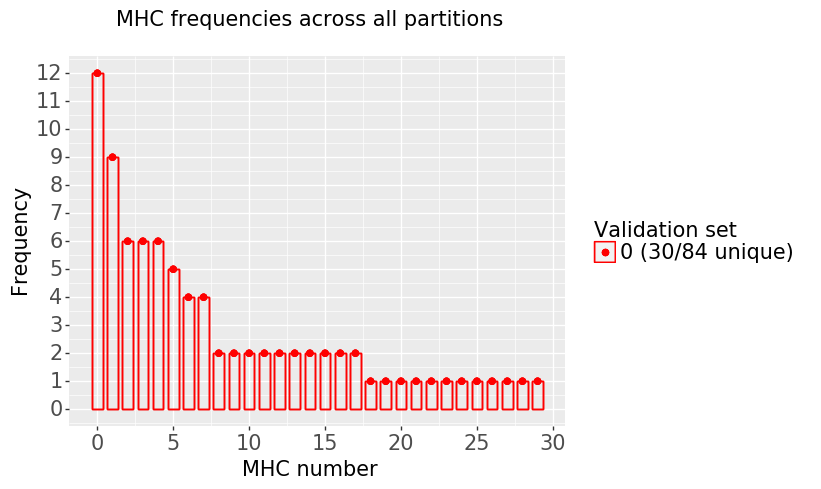

<ggplot: (-9223363292371237751)>

In [128]:
dfs = []
for i in range(0, 5):
    melt_df = pd.DataFrame(Counter(peps[i]).most_common())
    melt_df[0] = melt_df.index
    melt_df.columns = ["variable", "value"]
    
    #text
    #unique = round((len(melt_df) / sum(melt_df["value"]))*100, 1)
    #text = str(i) + " (" + str(unique) + "% unique)"
    unique = str(len(melt_df)) + "/" + str(sum(melt_df["value"]))
    text = str(i) + " ("+ unique + " unique)"
    melt_df["Validation set"] = pd.DataFrame([text]*len(melt_df))
    dfs.append(melt_df)

plot = (ggplot(melt_df, aes("variable", "value"))
        #+ scale_color_discrete()
        + scale_y_continuous(
                            breaks = range(0, 90, 1))
        + scale_x_continuous(breaks = range(0,51, 5))
        + scale_color_manual(["red", "orange", "blue", "brown", "teal"])
        + ggtitle("MHC frequencies across all partitions\n")
        + xlab("MHC number")
        + ylab("Frequency")
        + theme(text = element_text(size = 15))
        
              )
for i in range(len(dfs)):
    plot = (plot + geom_bar(aes(color = "Validation set", fill = "Validation set"),
                            width = 0.7, stat = "identity", alpha = 0.0, data = dfs[0])
           )
for i in range(len(dfs)):
    plot = (plot + geom_point(aes(color = "Validation set"), alpha = 0.7, size = 2, data = dfs[0])
           )
#plot = plot + scale_fill_brewer(color = ['Greys']) 
plot = plot + scale_color_manual(["red", "orange", "blue", "brown", "teal"])

plot

In [219]:
dfs[2]

,variable,value,Validation set
0,0,13,2 (16.7% unique)
1,1,12,2 (16.7% unique)
2,2,5,2 (16.7% unique)
3,3,5,2 (16.7% unique)
4,4,5,2 (16.7% unique)
5,5,5,2 (16.7% unique)
6,6,5,2 (16.7% unique)
7,7,5,2 (16.7% unique)
8,8,5,2 (16.7% unique)
9,9,5,2 (16.7% unique)


In [80]:
pd.DataFrame(Counter(p0.append([p1, p2, p3, p4])).most_common())

,0,1
0,KLFDEVYFM--,20
1,TLSFDDTHYL-,17
2,ELAGIGILTV-,12
3,SLLMWITQC--,12
4,YYLPEFKAFL-,6
5,IMYDRTYYLP-,6
6,YFVMEYINGA-,6
7,TVSGNILTI--,6
8,ILTIRLIAA--,6
9,GVLLKEFTV--,6


In [263]:
pd.DataFrame(Counter(tp0.append([tp1, tp2, tp3, tp4])).most_common())

,0,1
0,---VEQDPGPLSVPEGAIVSLNCTYSNSAFQ-------YFMWYRQY...,42
1,---VEQNSGPLSVPEGAIASLNCTYSFLGSQ-------SFFWYRQY...,15
2,-QSVTQPDARVTVSEGASLQLRCKYSYSATP-------YLFWYVQY...,15
3,-QSVTQPDARVTVSEGASLQLRCKYSYSATP-------YLFWYVQY...,14
4,-QEVTQIPAALSVPEGENLVLNCSFTDSAIY-------NLQWFRQD...,13
5,--QNIDQPTEMTATEGAIVQINCTYQTSGFN-------GLFWYQQH...,12
6,---VEQNSGPLSVPEGAIASLNCTYSDRGSQ-------SFFWYRQY...,10
7,-----QSPQSMFIQEGEDVSMNCTSSSIFN--------TWLWYKQD...,10
8,-------PAALSVPEGENLVLNCSFTDSAIY-------NLQWFRQD...,10
9,---VTQIPAALSVPEGENLVLNCSFTDSAIY-------NLQWFRQD...,10


In [260]:
pd.DataFrame(Counter(mp0.append([mp1, mp2, mp3, mp4])).most_common())

,0,1
0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,216
1,GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTE...,30
2,GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,24
3,GPHSMRYYETATSRRGLGEPRYTSVGYVDDKEFVRFDSDAENPRYE...,17
4,GSHSMRYFDTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...,12
5,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKME...,12
6,GPHSLRYFVTAVSRPGLGEPRYMEVGYVDDTEFVRFDSDAENPRYE...,8
7,-SHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,6
8,GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTE...,6
9,GPHSMRYFETAVSRRGLGEPRYISVGYVDDKEFVRFDSDAENPRYE...,6


In [5]:
from collections import Counter
df0 = mp0.copy()
text = "Occurences of the same peptide in partition 4\n(" + str(unique) + " / " + str(total) + " peptides unique, " + str(value) + " %)"


df = df0
df = pd.DataFrame(Counter(df).most_common())
df.columns = ["0", "1"]

#unique count
df1 = pd.DataFrame(Counter(df0).most_common())
total = df1.loc[:, 1].sum()
unique = len(df1)
value = round(100 * (unique / total), 1)

(ggplot(df, aes(x = df.index, y = "1"))
 + geom_col(alpha = 1, width = 0.5)
 + geom_point(size = 0.5, alpha = 1, color = "red")
 + ggtitle(text)
 + scale_y_discrete(limits=range(1, 70, 1), breaks = range(1, 70, 2))
 + scale_x_discrete(limits=range(0, 55, 1), breaks = range(0, 55, 5))
 + xlab("Peptide number")
 + ylab("Occurences")
 + theme_classic()
)

NameError: name 'mp0' is not defined

### Create files for TCR and MHC similarities

# !realpath /home/maghoi/main/data/02_Features/*

### LOAD Data. Graph similarity matrix

In [93]:
#Note: 1464 rows
df_raw = pd.read_feather("/home/maghoi/main/data/02_Features/Peptide_Matrix.feather")
df_names = pd.read_feather("/home/maghoi/main/data/02_Features/PeptideNames_Matrix.feather")

#df_tcr_raw = pd.read_feather("/home/maghoi/main/data/02_Features/")
#df_tcr_names = pd.read_feather("/home/maghoi/main/data/02_Features/PeptideNames_Matrix.feather")

#Note: 366 rows (1464 / 4)
df_mhc_raw = pd.read_feather("/home/maghoi/main/data/02_Features/MHC_Matrix.feather")
#df_mhc_names = pd.read_feather("/home/maghoi/main/data/02_Features/PeptideNames_Matrix.feather")

df_tcr_raw = pd.read_feather("/home/maghoi/main/data/02_Features/TCR_Matrix.feather")

#Reset index
df_raw = df_raw.set_index(df_raw.iloc[:, 0]).drop(columns="index")
df_names = df_names.set_index(df_names.iloc[:, 0]).drop(columns="index")

In [228]:
df_raw = pd.read_feather("/home/maghoi/main/data/02_Features/Peptide_Matrix.feather")
df_names = pd.read_feather("/home/maghoi/main/data/02_Features/PeptideNames_Matrix.feather")


In [94]:
int_names = []
for i in range(0, 1464, 1):
    int_names.append(str(i))
    
    
#int_names = []
#for i in range(0, 366, 1):
#    int_names.append(str(i))

In [95]:
#set int names range 0 - 366
df2 = df_raw.copy()
df2.columns = int_names
df2.index = int_names
name_list = df_names.index

#### --- temp ---

In [265]:
## All data (no ordered partitions)
df2.shape
p0 = df2[0:293]
p1 = df2[293:586]
p2 = df2[586:879]
p3 = df2[879:1172]
p4 = df2[1172:1464]


In [272]:
name_list

Index(['1g6r_1p_N1_1t_80s_pMHC-TCR', '3tjh_4p_P1_1t_90s_pMHC-TCR',
       '2bnq_2p_P1_1t_99s_pMHC-TCR', '1g6r_1p_N1_1t_90s_pMHC-TCR',
       '1g6r_1p_N1_1t_95s_pMHC-TCR', '1mwa_1p_N3_1t_99s_pMHC-TCR',
       '1mwa_1p_P1_1t_80s_pMHC-TCR', '1mwa_1p_P1_1t_90s_pMHC-TCR',
       '1mwa_1p_P1_1t_95s_pMHC-TCR', '1mwa_1p_P1_1t_99s_pMHC-TCR',
       ...
       '1mwa_1p_N1_1t_90s_pMHC-TCR', '1mwa_1p_N1_1t_95s_pMHC-TCR',
       '1mwa_1p_N1_1t_99s_pMHC-TCR', '1mwa_1p_N2_1t_80s_pMHC-TCR',
       '1mwa_1p_N2_1t_90s_pMHC-TCR', '1mwa_1p_N2_1t_95s_pMHC-TCR',
       '1mwa_1p_N2_1t_99s_pMHC-TCR', '1mwa_1p_N3_1t_80s_pMHC-TCR',
       '1mwa_1p_N3_1t_90s_pMHC-TCR', '1mwa_1p_N3_1t_95s_pMHC-TCR'],
      dtype='object', name='index', length=1464)

#### --- Temp end ---

#### Correcting 1464 df_raw and df_names to 366, 366

In [97]:
# As the sets with 4 template idendity thresholds for modelling (99, 95, 90, 80 % thresholds)
# all contain the same sequences, 3/4 sequences are replicates and can be removed

def extract_4th_col_row(df, axis):
    cols = []
    if axis == 1:
        for i in range(0, df.shape[1], 4):
            cols.append(i)
        return df.iloc[:, cols]
    
    if axis == 0:
        for i in range(0, df.shape[0], 4):
            cols.append(i)
        return df.iloc[cols]

In [98]:
#Hack name_list to 366 rows instead of 1464
if len(name_list) > 366:
    name_list = pd.Series(extract_4th_col_row(pd.DataFrame(name_list), 0).reset_index(drop = True)["index"])
    
if len(df_raw) > 366:
    df_raw = extract_4th_col_row((extract_4th_col_row(df_raw, 0)), 1)
    
name_list.shape, df_raw.shape

((366,), (366, 366))

In [99]:
#0:77
#77:149
#149:220
#220:292
#292:336

#### Choice: Complex: averaging alignment identity of tcr, mhc and peptide

In [100]:
df_tcr_raw.shape, df_mhc_raw.shape, df_raw.shape

((366, 366), (366, 366), (366, 366))

In [101]:
# Values for each row of peptides, tcr and mhc alignment identities are added
# and divided by 3 to give 1/3 weight to each

df_avg = np.zeros(shape = (366, 366))
for i in range(len(df_avg)):
    df_avg[i] = df_raw.values[i] + df_mhc_raw.values[i] + df_tcr_raw.values[i]
df_avg = df_avg / 3
df_avg = pd.DataFrame(df_avg)

#### Set df to use:

In [102]:
### SET DF TO GRAPH ###
df2 = df_avg.copy() #Change this line
###

df2.index = range(0, 366)
df2.columns = range(0, 366)
df2.columns = df2.columns.astype(np.int64)
df2.index = df2.index.astype(np.int64)
#name_list = extract_4th_col_row(name_list)


#### Choice: no partitions or partitions

In [172]:
# random partitions (filenames)

#0:77
#77:149
#149:220
#220:292
#292:366
p0 = df2[0:77]
p1 = df2[77:149]
p2 = df2[149:220]
p3 = df2[220:292]
p4 = df2[292:366]


In [70]:
# raw partitions
#ix_train = 1080 (270 or 0:270)
#ix_val = 256 (64 or 270:334)
#ix_test = 128 (32 or 334:366)
#data_size=1464

p0 = df2[0:270]
p1 = df2[270:334]
p2 = df2[334:366]

np0 = p0[p0.index]
np1 = p1[p1.index]
np2 = p2[p2.index]

In [103]:
#Extract partitions according to indices in name_list
p0 = df2[name_list.str.contains(".*0p.*")]
p1 = df2[name_list.str.contains(".*1p.*")]
p2 = df2[name_list.str.contains(".*2p.*")]
p3 = df2[name_list.str.contains(".*3p.*")]
p4 = df2[name_list.str.contains(".*4p.*")]

#not used
#Append all rows together (1464 x 1464)
#df = p0.append([p1,p2,p3,p4])

#Append all columns together in new df (1464 x 1464)
#df = pd.concat((df[p0.index], df[p1.index], df[p2.index], df[p3.index], df[p4.index]), axis=1)

#Use only every 4th column and row (rest are exactly the same)
#df = extract_4th_col_row(df, 0)
#df = extract_4th_col_row(df, 1)

In [142]:
test = df_names.copy()

In [177]:
n0 = list(pd.Series(test.index).str.contains(".*_0p.*"))
n1 = list(pd.Series(test.index).str.contains(".*_1p.*"))
n2 = list(pd.Series(test.index).str.contains(".*_2p.*"))
n3 = list(pd.Series(test.index).str.contains(".*_3p.*"))
n4 = list(pd.Series(test.index).str.contains(".*_4p.*"))

In [180]:
master = np.array(test)

In [203]:
temp = master.copy()
temp[0:100]

array([[1.  , 0.  , 0.11, ..., 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.22, ..., 0.11, 0.11, 0.11],
       [0.11, 0.22, 1.  , ..., 0.11, 0.11, 0.11],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [122]:
test.loc[:, pd.Series(test.index)] = 0

### pretty graph attempt

In [64]:
#Only extract columns which are within the partition
np0 = p0[p0.index]
np1 = p1[p1.index]
np2 = p2[p2.index]
np3 = p3[p3.index]
np4 = p4[p4.index]

#remove 3/4 peptides for both rows and columns
#np0 =  extract_4th_col_row((extract_4th_col_row(np0, 0)), 1)
#np1 =  extract_4th_col_row((extract_4th_col_row(np1, 0)), 1)
#np2 =  extract_4th_col_row((extract_4th_col_row(np2, 0)), 1)
#np3 =  extract_4th_col_row((extract_4th_col_row(np3, 0)), 1)
#np4 =  extract_4th_col_row((extract_4th_col_row(np4, 0)), 1)


#### Choice: Master, uber-index

In [174]:
### With huge weight! ###

def master_index(df):
    #Sorts row/columns by highest average identity value per row/column
    #Gives huge weight for exact (100 %) matches, clustering exact replicates
    df = pd.DataFrame(df.apply(lambda x: np.where(x == 1, x*300, x)))
    master_index = df.apply(np.average, axis = 1).sort_values(ascending = False).index
    return master_index


In [68]:
### Without huge weight! ### 

def master_index(df):
    #Sorts row/columns by highest average identity value per row/column
    master_index = df.apply(np.average, axis = 1).sort_values(ascending = False).index
    return master_index


In [15]:
#no partitions
#uber_index = master_index(df2)
#df3 = df2.loc[uber_index, uber_index.copy()]

uber_index = master_index(np0).append((master_index(np1),
                                       master_index(np2)))

df3 = df2.loc[uber_index, uber_index].copy()

In [69]:
# Uber_index collects all master_index´s, thus each partition is sorted to cluster close matches
uber_index = master_index(np0).append((master_index(np1),
                                       master_index(np2),
                                       master_index(np3),
                                       master_index(np4)))
#Uses original dataframe (TCR/pep/MHC) with the newly sorted uber_index
df3 = df2.loc[uber_index, uber_index].copy()

#### Choice: Non master-uber-index

In [296]:
# Not using uber-index
uber_index = np0.index.append((np1.index, np2.index, np3.index, np4.index))
df3 = df2.loc[uber_index, uber_index].copy()

#### Raw partition

In [74]:
# raw partitions
#ix_train = 1080 (270 or 0:270)
#ix_val = 256 (64 or 270:334)
#ix_test = 128 (32 or 334:366)
#data_size=1464

#df3.index = range(0, 366)
#df3.columns = range(0, 366)

#Keep track of partition sizes for next step
shapes = 0, 270, 64, 32
ix_names = pd.Series(range(0, 366, 1))
count = 0

#Reset index/column names to range while adding separator to create distance between partitions
for i in range(1, len(shapes)-1):
    count += shapes[i]
    ix_names[count : 366] += 5
df3.index = ix_names
df3.columns = ix_names
df3.shape

(366, 366)

#### Create similarity graph

In [75]:
n0 = list(range(0,77))
n1 = list(range(77,149))
n2 = list(range(149,220))
n3 = list(range(220,292))
n4 = list(range(292,366))

In [135]:
n0_name = pd.Series(glob.glob("/home/maghoi/pMHC_data/features11/*0p*")).apply(lambda x: x[34:])
n1_name = pd.Series(glob.glob("/home/maghoi/pMHC_data/features11/*1p*")).apply(lambda x: x[34:])
n2_name = pd.Series(glob.glob("/home/maghoi/pMHC_data/features11/*2p*")).apply(lambda x: x[34:])
n3_name = pd.Series(glob.glob("/home/maghoi/pMHC_data/features11/*3p*")).apply(lambda x: x[34:])
n4_name = pd.Series(glob.glob("/home/maghoi/pMHC_data/features11/*4p*")).apply(lambda x: x[34:])
name_list = n0_name.append([n1_name,n2_name,n3_name,n4_name])
name_list = name_list.reset_index(drop = True)

In [91]:
np.amax(df3.loc[229, :])

1.0

In [ ]:
# similarity graph done

In [177]:
#Tobias partitions

#Keep track of partition sizes for next step
shapes = 0, len(np0), len(np1), len(np2), len(np3), len(np4)
ix_names = pd.Series(range(0, 366, 1))
count = 0

#Reset index/column names to range while adding separator to create distance between partitions
for i in range(1, len(shapes)-1):
    count += shapes[i]
    ix_names[count : 366] += 5
df3.index = ix_names
df3.columns = ix_names
df3.shape


(366, 366)

In [19]:
np.amin(df3.values)

0.35562628446366135

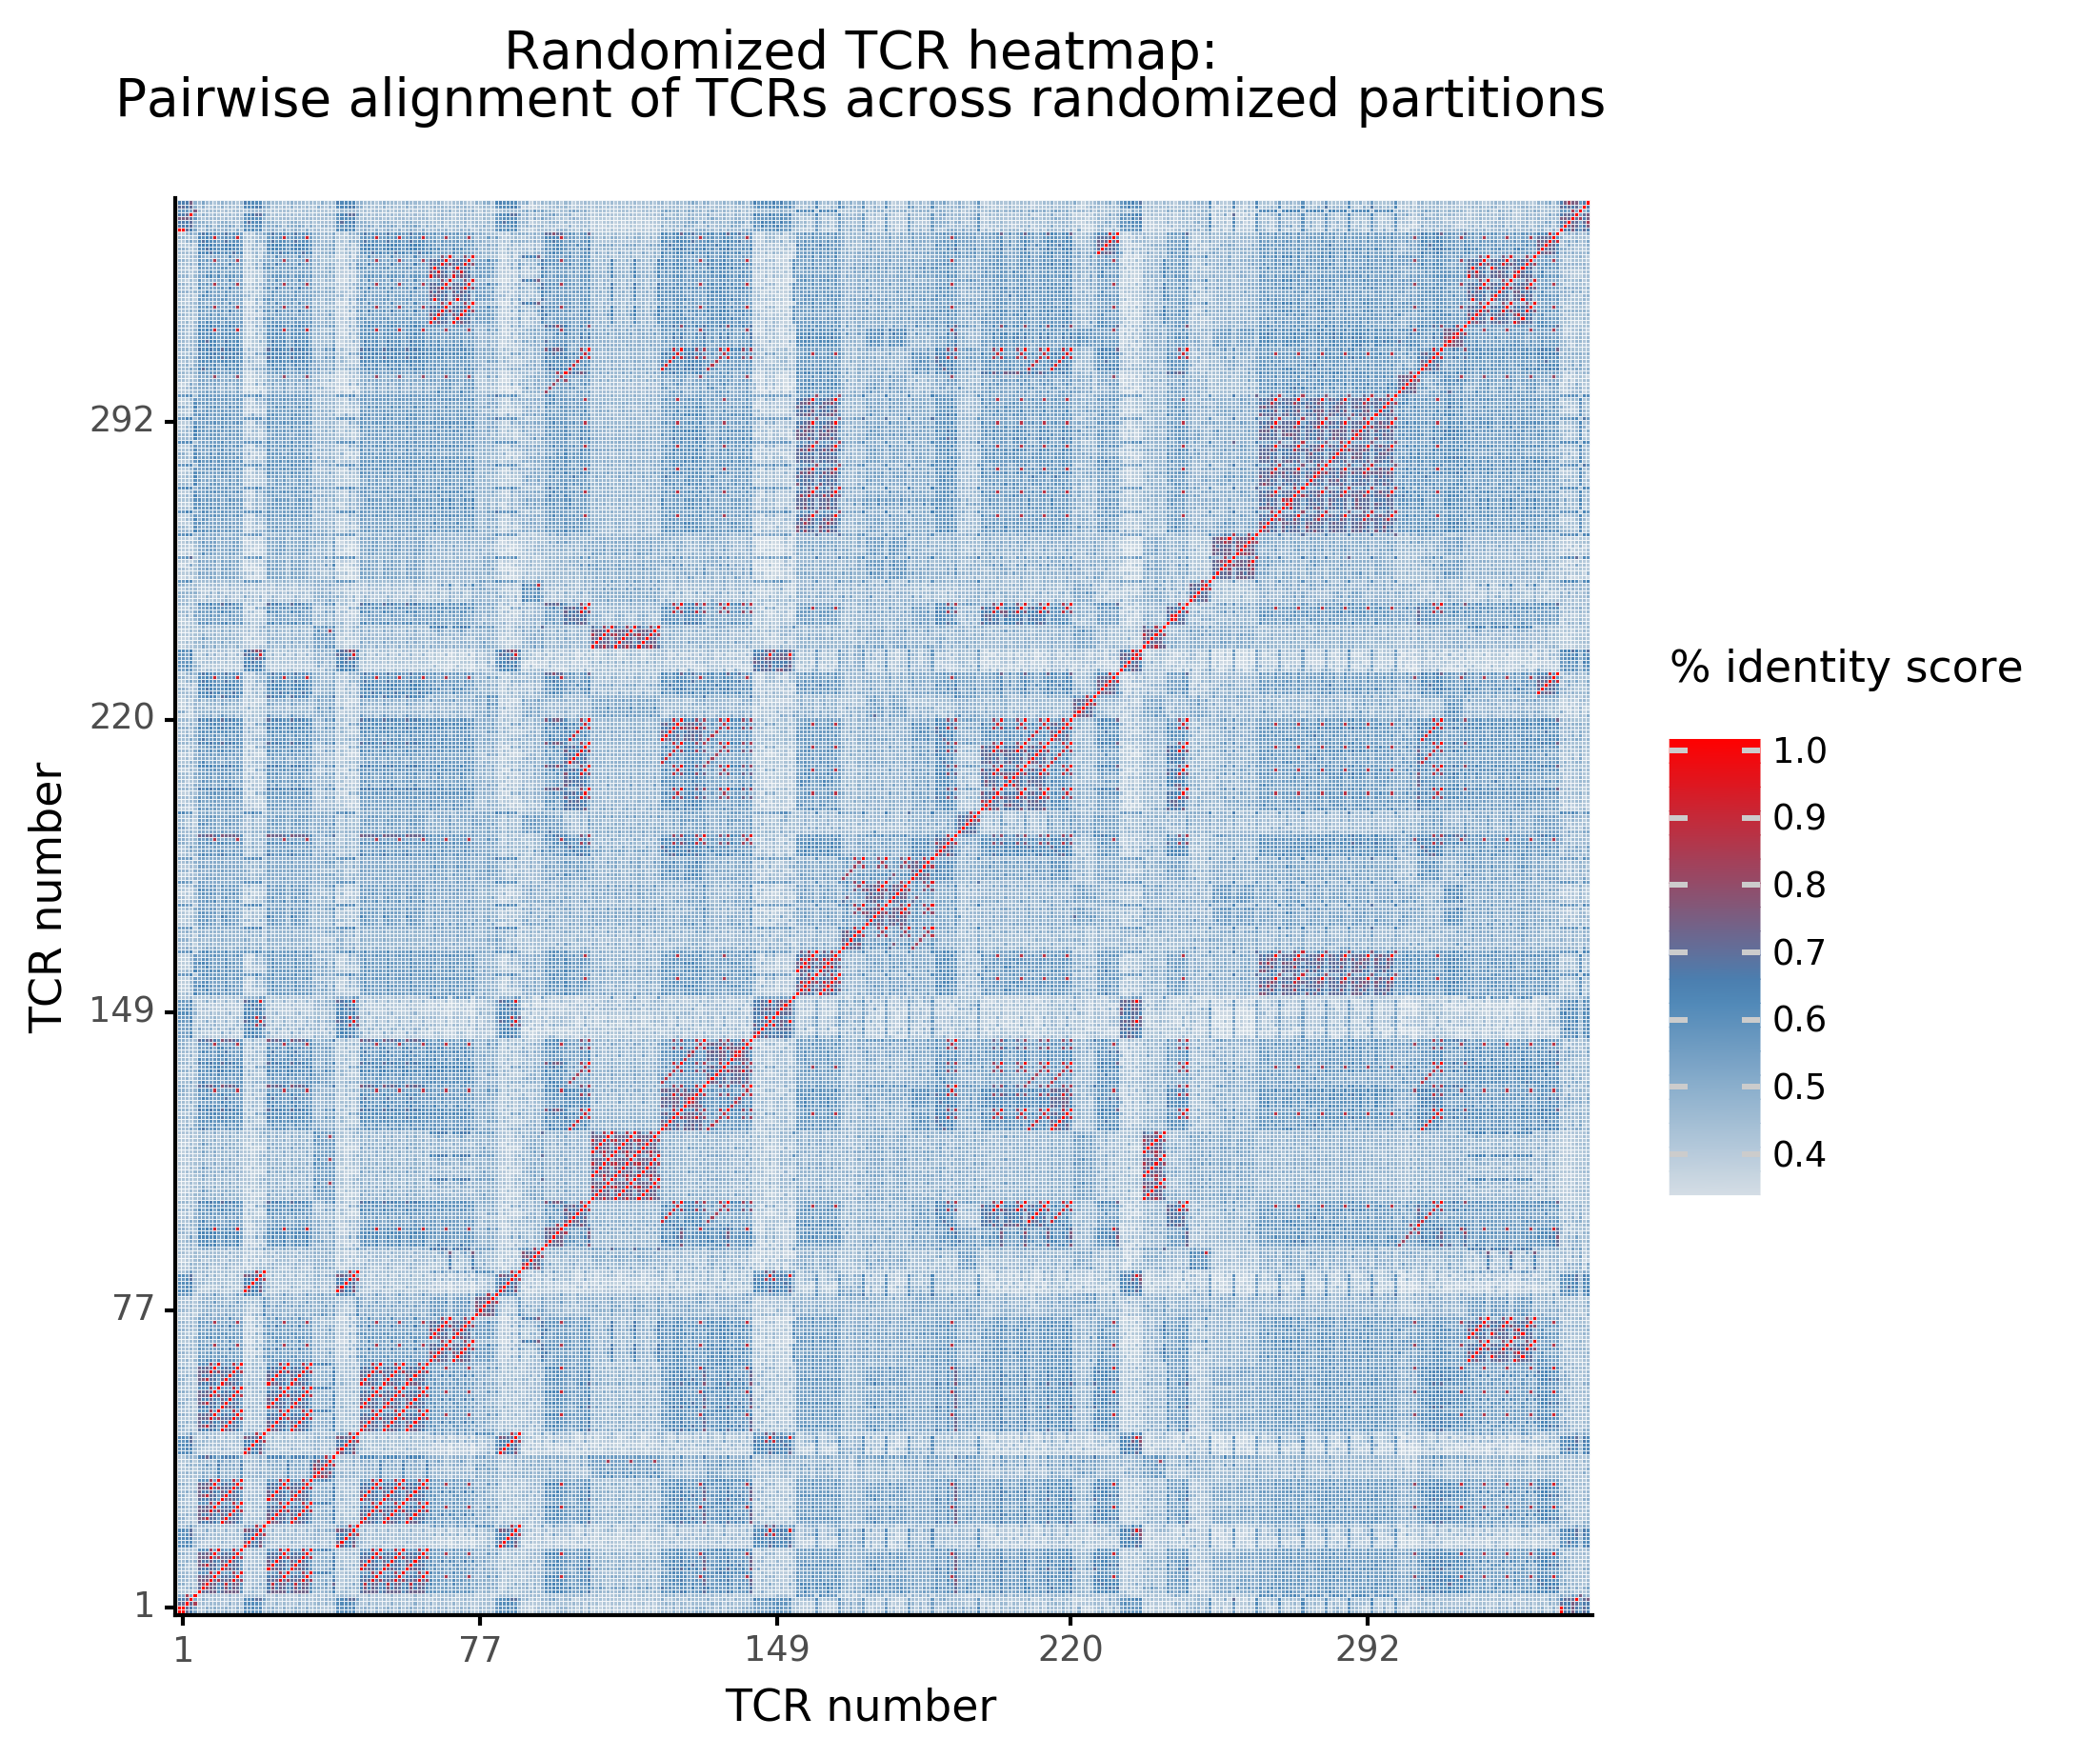

<ggplot: (8785768526042)>

In [18]:
# raw partitions
#Create plot
melt_df = pd.melt(df3.iloc[:, :])
melt_df["variable2"] = np.tile(df3.index, df3.shape[1])
melt_df.variable = melt_df.variable.astype(int) #Necessary for integer ordering vs alphabetical
    
(ggplot(melt_df, aes("variable", "variable2"))
 + geom_tile(aes(fill = "value"), color = "white")
 + coord_equal()
 + scale_fill_gradient2(name = "% identity score\n\n", low='#eeeeee', mid = "steelblue", high='red', midpoint = 0.65,
                        breaks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                        labels = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
                        #breaks = [0.652, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
                        #labels = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
 #+ theme(axis_text_x=element_text(size = 8))
 
 + ggtitle("Randomized TCR heatmap:\nPairwise alignment of TCRs across randomized partitions\n")
 + xlab("TCR number")
 + ylab("TCR number")
 + theme_classic()
 + theme(dpi = 300)
 + scale_x_discrete(limits=range(0, 366), breaks = [0, 77, 149+5, 220+10, 292+15, 364+20], labels = [1, 77, 149, 220, 292, 366])
 + scale_y_discrete(limits=range(0, 366), breaks = [0, 77, 149+5, 220+10, 292+15, 364+20], labels = [1, 77, 149, 220, 292, 366])
 #+ theme(figure_size =(15,15), text = element_text(size = 18))
 #+ scale_x_discrete(limits=range(0, 366), breaks = [0, 100, 162+5, 234+10, 300+15, 364+20], labels = [1, 84, 162, 234, 300, 366])
 #+ scale_y_discrete(limits=range(0, 366), breaks = [0, 83, 162+5, 234+10, 300+15, 364+20], labels = [1, 84, 162, 234, 300, 366])
)



In [23]:
#Partitions
#Create plot
melt_df = pd.melt(df3.iloc[:, :])
melt_df["variable2"] = np.tile(df3.index, df3.shape[1])
melt_df.variable = melt_df.variable.astype(int) #Necessary for integer ordering vs alphabetical

(ggplot(melt_df, aes("variable", "variable2"))
 + geom_tile(aes(fill = "value"), color = "white")
 + coord_equal()
 + scale_fill_gradient2(name = "% identity score\n\n", low='#eeeeee', mid = "steelblue", high='red', midpoint = 0.7,
                        breaks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                        labels = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
                        #breaks = [0.652, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
                        #labels = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
 #+ theme(axis_text_x=element_text(size = 8))
 
 + ggtitle("Complex heatmap:\nPairwise alignment of TCR:p:MHC complexes across partitions\n")
 + xlab("Complex number")
 + ylab("Complex number")
 + theme_classic()
 + theme(dpi = 300)
 #+ theme(figure_size =(15,15), text = element_text(size = 18))
 + scale_x_discrete(limits=range(0, 386), breaks = [0, 83, 162+5, 234+10, 300+15, 364+20], labels = [1, 84, 162, 234, 300, 366])
 + scale_y_discrete(limits=range(0, 386), breaks = [0, 83, 162+5, 234+10, 300+15, 364+20], labels = [1, 84, 162, 234, 300, 366])
)

PlotnineError: 'Breaks and labels are different lengths. Make sure all the breaks you specify are with in the limits.'

In [24]:
np.amin(df3.values)

0.6519337016574586

In [36]:
shapes

(0, 84, 79, 72, 66, 65)

In [35]:
df3.shape

(366, 366)

In [31]:
df3.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            376, 377, 378, 379, 380, 381, 382, 383, 384, 385],
           dtype='int64', length=366)

In [286]:
len(name_list)

366

TypeError: map() must have at least two arguments.

In [208]:
map(int, range(0, 1.1, 0.1))

TypeError: 'float' object cannot be interpreted as an integer

In [11]:
#Reset peptide names
df2 = df.copy()
df2.columns = range(0, 366)
df2.index = range(0, 366)
df2.shape

(366, 366)

In [12]:
shapes = int(0), int(len(p0)/4), int(len(p1)/4), int(len(p2)/4), int(len(p3)/4), int(len(p4)/4)

ix_names = pd.Series(range(0, 366, 1))
count = 0

#add separator (+5) to index names to separate partitions in heatmap
for i in range(1, len(shapes)-1):
    count += shapes[i]
    ix_names[count : 366] += 5
df2.index = ix_names
df2.columns = ix_names

In [13]:
# Plot

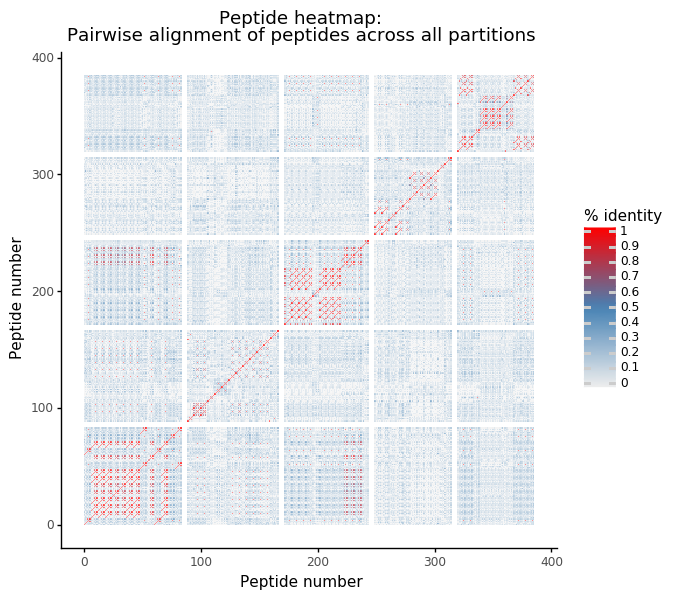

<ggplot: (8755243265947)>

In [14]:
melt_df = pd.melt(df2.iloc[:, :])
melt_df["variable2"] = np.tile(df2.index, 366)
melt_df.variable = melt_df.variable.astype(int) #Necessary for integer ordering vs alphabetical

(ggplot(melt_df, aes("variable", "variable2"))
 + geom_tile(aes(fill = "value"), color = "white")
 + coord_equal()
 + scale_fill_gradient2(name = "% identity", low='#eeeeee', mid = "steelblue", high='red', midpoint = 0.5, breaks = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])
 + theme(axis_text_x=element_text(size = 8))
 + theme(figure_size =(15,15))
 + ggtitle("Peptide heatmap:\nPairwise alignment of peptides across all partitions")
 + xlab("Peptide number")
 + ylab("Peptide number")
 + theme_classic()
 #+ scale_x_discrete(limits=range(0, 1465, 1), breaks = range(0, 1465, 100))
 #+ scale_y_discrete(limits=range(0, 1465, 1), breaks = range(0, 1465, 100))
 #+ scale_y_discrete(breaks=range(0, 100, 10), limits=(0, 100))
)